In [1]:
#Estas las agregue yo, ojo h5py no me funciono con python 3.10 y baje a 3.8

#!pip install h5py
#!pip install matplotlib
#!pip install matplotlib_inline
#!pip install sklearn
#!pip install xgboost
#!pip install Scikit-learn
#!pip install ipywidgets
#!pip install ipywidgets widgetsnbextension pandas-profiling
#!pip install tqdm

### Dataset

https://www.kaggle.com/datasets/aleespinosa/soccer-match-event-dataset

https://github.com/mferrad/fot-valuing-actions

https://www.kaggle.com/code/aleespinosa/friendsoftracking-valuing-actions-in-football-1
https://www.kaggle.com/code/aleespinosa/friendsoftracking-valuing-actions-in-football-2
https://www.kaggle.com/code/aleespinosa/friendsoftracking-valuing-actions-in-football-3
https://www.kaggle.com/code/aleespinosa/friendsoftracking-valuing-actions-in-football-4

Este podria servir despues
https://www.kaggle.com/datasets/kriegsmaschine/soccer-players-values-and-their-statistics

In [2]:
#!jupyter nbextension enable --py widgetsnbextension

In [3]:
!pip install tables==3.6.1
!pip install socceraction==0.2.0

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
from ast import literal_eval
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep.formula import value
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

In [5]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

### Preprocess the Wyscout data
The following cells read the corresponding csv files from the Kaggle dataset, save them as part of the wyscout.h5 file with different keys.

### Teams

In [6]:
df_teams = pd.read_csv('teams.csv', encoding='unicode_escape')
df_teams.to_hdf('wyscout.h5', key='teams', mode='w')
df_teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


### Players

In [7]:
df_players = pd.read_csv('players.csv', encoding='unicode_escape')
df_players.to_hdf('wyscout.h5', key='players', mode='a')
df_players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,NaN,Tekin,4502.0,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687.0
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,NaN,Sarr,3775.0,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423.0
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,NaN,Mandanda,3772.0,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,NaN,O. Mandanda,NaN
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,NaN,N'Diaye,683.0,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314.0
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,NaN,Konaté,2975.0,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,NaN


### Matches

In [8]:
#tmp_df_competition2 = pd.read_csv(f'matches_Spain.csv', encoding='unicode_escape')
#tmp_df_competition2.head()
#tmp_df_competition2['teamsData'].apply(literal_eval)
#literal_eval se asegura que lo lea como diccionrio:
#The literal_eval safely evaluate an expression node or a string containing a Python literal or container display. The string or node (a file) provided may only consist of the following Python literal structures: strings, bytes, numbers, tuples, lists, dicts, sets, booleans, and None.

In [9]:
competitions = [
     'England',
     'France',
     'Germany',
     'Italy',
    'Spain',
    'European_Championship',
    'World_Cup'
]

dfs_matches = []
for competition in competitions:
    tmp_df_competition = pd.read_csv(f'matches_{competition}.csv', encoding='unicode_escape')
    tmp_df_competition['teamsData'] = tmp_df_competition['teamsData'].apply(literal_eval)   ### sometimes dicts inside csv files need different treatment
    dfs_matches.append(tmp_df_competition)
df_matches = pd.concat(dfs_matches)
df_matches.to_hdf('wyscout.h5', key='matches', mode='a')
df_matches.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,...,team2.teamId,team2.score,team2.scoreP,team2.hasFormation,team2.formation,team2.scoreHT,team2.formation.bench,team2.formation.lineup,team2.formation.substitutions,groupName
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",...,1659,2,0,1,"{'bench': [{'playerId': 11061, 'ownGoals': '0'...",0,"[{'playerId': 11061, 'ownGoals': '0', 'redCard...","[{'playerId': 259531, 'ownGoals': '0', 'redCar...","[{'playerIn': 7989, 'playerOut': 259531, 'minu...",NaN
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0",...,1627,0,0,1,"{'bench': [{'playerId': 399517, 'ownGoals': '0...",0,"[{'playerId': 399517, 'ownGoals': '0', 'redCar...","[{'playerId': 25537, 'ownGoals': '0', 'redCard...","[{'playerIn': 261, 'playerOut': 25537, 'minute...",NaN
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1",...,1673,0,0,1,"{'bench': [{'playerId': 274482, 'ownGoals': '0...",0,"[{'playerId': 274482, 'ownGoals': '0', 'redCar...","[{'playerId': 9419, 'ownGoals': '0', 'redCards...","[{'playerIn': 38377, 'playerOut': 9419, 'minut...",NaN
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0",...,1612,4,0,1,"{'bench': [{'playerId': 74, 'ownGoals': '0', '...",2,"[{'playerId': 74, 'ownGoals': '0', 'redCards':...","[{'playerId': 25747, 'ownGoals': '2', 'redCard...","[{'playerIn': 8140, 'playerOut': 25747, 'minut...",NaN
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0",...,1611,1,0,1,"{'bench': [{'playerId': 7918, 'ownGoals': '0',...",1,"[{'playerId': 7918, 'ownGoals': '0', 'redCards...","[{'playerId': 7939, 'ownGoals': '0', 'redCards...","[{'playerIn': 8135, 'playerOut': 7939, 'minute...",NaN


### Events

In [10]:
#df_events2 = pd.read_csv(f'events_spain.csv', encoding='unicode_escape')
#df_events2.head()
#df_events2['tags'] = df_events2['tags'].apply(literal_eval) 
#df_events2.head()
#df_events_matches2 = df_events2.groupby('matchId', as_index=False) #hace esto para poder iterar por partido, sino no funca el for
#df_events_matches2.head()

#df_events

In [11]:
for competition in competitions:
    df_events = pd.read_csv(f'events_{competition}.csv', encoding='unicode_escape')
    df_events['tags'] = df_events['tags'].apply(literal_eval)
    df_events['positions'] = df_events['positions'].apply(literal_eval)
    df_events_matches = df_events.groupby('matchId', as_index=False)
    for match_id, df_events_match in df_events_matches:
#         display(df_events_match.head())
        df_events_match.to_hdf('wyscout.h5', key=f'events/match_{match_id}', mode='a')

### Convert the Wyscout data to the SPADL representation

The following cell calls the convert_to_spadl function from the socceraction library to convert the wyscout.h5 HDF5 file into the spadl.h5 HDF5 file.

In [12]:
convert_to_spadl('wyscout.h5', 'spadl.h5')

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|████████████████████████████████████████████████████████████████████████████| 1941/1941 [05:11<00:00,  6.24game/s]


...Converting events to actions


100%|████████████████████████████████████████████████████████████████████████████| 1941/1941 [31:29<00:00,  1.03game/s]


### Value game states

This section generates features and labels for the game states, trains a predictive machine learning model for each label, and values the game states by applying the trained machine learning models.

Generate the features to describe the game states;
Generate the labels that capture the value of the game states;
Compose a dataset by selecting a set of features and the labels of the game states;
Train predictive machine learning models using the dataset;
Value the game states using the trained predictive machine learning model.

In [13]:
df_games = pd.read_hdf('spadl.h5', key='games')
df_actiontypes = pd.read_hdf('spadl.h5', key='actiontypes')
df_bodyparts = pd.read_hdf('spadl.h5', key='bodyparts')
df_results = pd.read_hdf('spadl.h5', key='results')

In [14]:
#df_games.head()
#df_actiontypes.head()
#df_bodyparts.head()
#df_results.head()

In [15]:
nb_prev_actions = 3
#define un gamestate como 3 acciones consecutivas 

### Generate game state features

The following cell lists a number of feature generators from the features module in the socceraction library. Each function expects either a DataFrame object containing actions (i.e., individual actions) or a list of DataFrame objects containing consecutive actions (i.e., game states), and returns the corresponding feature for the individual action or game state.

For a list of the actions in features follow this link.

In [16]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

The following cell generates game states from consecutive actions in each game and computes the features for each game state.

1. Obtain the actions for the game (i.e., df_actions) by looping through the games;
2. Construct game states of a given length from the actions (i.e., dfs_gamestates);
3. Compute the features for the constructed game states (i.e., df_features) by looping through the list of feature generators.

In [17]:
#df_games.iterrows()
#tqdm is a Python library that provides functions that wrap around the specified iterable to give a smart progress bar as an output.
#df_games.head()
#df_actions.head() #aca mergea los datos que viene de games, agrega a izquierda el action type, result y bodypart a las acciones para cada partido 
#dfs_gamestates[1] # transforma las acciones a gamestates (entiendo que el conjunto de 3)
#df_features.head() #llama a los generadores de features y agrega mas features


In [18]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    dfs_gamestates = features.gamestates(df_actions, nb_prev_actions=nb_prev_actions)
    dfs_gamestates = features.play_left_to_right(dfs_gamestates, game['home_team_id'])
    
    df_features = pd.concat([function(dfs_gamestates) for function in functions_features], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')

  0%|          | 0/1941 [00:00<?, ?it/s]

### Generate game state labels

The following cell lists a number of label generators from the labels module in the socceraction library. Each function expects either a DataFrame object containing actions (i.e., individual actions) or a list of DataFrame objects containing consecutive actions (i.e., game states), and returns the corresponding label for the individual action or game state.

In [19]:
functions_labels = [
    labels.scores,
    labels.concedes
]

The following cell computes the labels for each action:

1. Obtain the actions for the game (i.e., df_actions) by looping through the games;
2. Compute the labels for the actions (i.e., df_labels) by looping through the list of label generators.

In [20]:
#Esto es lo mismo que el anterior, se tiene que poder juntar

In [21]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    df_labels = pd.concat([function(df_actions) for function in functions_labels], axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

  0%|          | 0/1941 [00:00<?, ?it/s]

### Generate dataset
The following cell generates a list of names for the features to be included in the dataset.

In [22]:
columns_features = features.feature_column_names(functions_features, nb_prev_actions=nb_prev_actions)

The following cell obtains the relevant features for each game and stores them in the df_features DataFrame object.

In [23]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    dfs_features.append(df_features[columns_features])
df_features = pd.concat(dfs_features).reset_index(drop=True)

  0%|          | 0/1941 [00:00<?, ?it/s]

In [24]:
df_features.head(10)
# df_features.shape

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,63.091679,0.053916,63.091679,0.053916,63.091679,0.053916,True,True,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,68.328929,0.355773,63.091679,0.053916,63.091679,0.053916,True,True,1.997756,1.997756
2,True,False,False,False,False,False,False,False,False,False,...,73.715416,0.185556,68.328929,0.355773,63.091679,0.053916,True,True,0.771744,2.769500
3,True,False,False,False,False,False,False,False,False,False,...,38.707772,0.396818,73.715416,0.185556,68.328929,0.355773,True,True,2.174464,2.946208
4,True,False,False,False,False,False,False,False,False,False,...,37.425928,0.620467,38.707772,0.396818,73.715416,0.185556,True,True,3.907382,6.081846
5,True,False,False,False,False,False,False,False,False,False,...,30.729141,1.258205,37.425928,0.620467,38.707772,0.396818,True,True,3.758730,7.666112
6,False,True,False,False,False,False,False,False,False,False,...,8.400000,0.000000,30.729141,1.258205,37.425928,0.620467,True,True,2.210584,5.969314
7,False,False,False,False,False,False,False,False,False,False,...,106.094842,0.246030,96.600000,0.000000,99.923872,0.296969,False,False,1.756122,3.966706
8,False,True,False,False,False,False,False,False,False,False,...,25.925192,1.489705,25.925192,1.489705,8.400000,0.000000,False,True,2.095783,3.851905
9,False,False,False,False,False,False,False,False,False,False,...,89.647658,0.388999,106.094842,0.246030,106.094842,0.246030,False,True,3.034782,5.130565


In [25]:
#print(df_features.columns.to_list())

The following cell lists the names of the labels to be included in the dataset.

In [26]:
columns_labels = [
    'scores',
    'concedes'
]

The following cell obtains the relevant labels for each game and stores them in the df_labels DataFrame object.

In [27]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    dfs_labels.append(df_labels[columns_labels])
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

  0%|          | 0/1941 [00:00<?, ?it/s]

In [28]:
df_labels.head(10)

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


### Train classifiers
The following cell trains an XGBoost classifier for each label using the computed features. For each label:

1. Construct an XGBoost classifier with default hyperparameters;
2. Train the classifier using the computed features and the label;
3. Store the trained classifier in the models dict.

In [29]:
%%time
models = {}
for column_labels in columns_labels:
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(df_features, df_labels[column_labels])
    models[column_labels] = model

c:\users\martin\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


CPU times: total: 3h 54min 42s
Wall time: 31min 59s


Score model for scores:  0.986639506442304
Score model for concedes:  0.9951429664498744


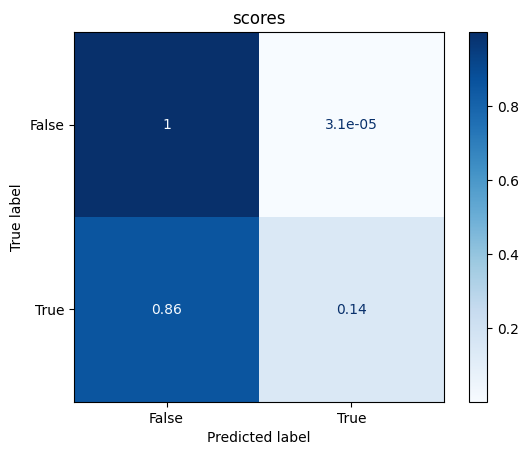

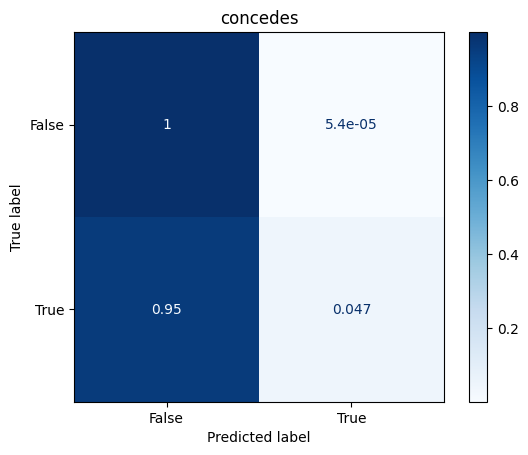

In [30]:
for column_labels in columns_labels:
    print(f'Score model for {column_labels}: ', models[column_labels].score(df_features, df_labels[column_labels]))
    disp = ConfusionMatrixDisplay.from_estimator(
        models[column_labels],
        df_features,
        df_labels[column_labels],
        cmap=plt.cm.Blues,
        normalize="true",
    )
    disp.ax_.set_title(column_labels)

### Estimate probabilities

The following cell predicts the labels for the game states using the trained XGBoost classifier. For each label:

1. Retrieve the model for the label;
2. Estimate the probabilities of the labels being False and True given the computed features;
3. Keep the probabilities for the True label;
4. Store the probabilities as a Series object in the dfs_predictions dict.

In [31]:
dfs_predictions = {}
for column_labels in columns_labels:
    model = models[column_labels]
    probabilities = model.predict_proba(df_features)
    predictions = probabilities[:, 1]
    dfs_predictions[column_labels] = pd.Series(predictions)
df_predictions = pd.concat(dfs_predictions, axis=1)

In [32]:
df_predictions.head(10)

,scores,concedes
0,0.003273,0.001907
1,0.004708,0.001667
2,0.003852,0.002665
3,0.010250,0.002063
4,0.016419,0.001796
5,0.023454,0.001320
6,0.013118,0.001563
7,0.001964,0.012750
8,0.012684,0.002059
9,0.003206,0.007819


The following cell obtains the game_id for each action in order to store the predictions per game.

In [33]:
dfs_game_ids = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    dfs_game_ids.append(df_actions['game_id'])
df_game_ids = pd.concat(dfs_game_ids, axis=0).astype('int').reset_index(drop=True)

  0%|          | 0/1941 [00:00<?, ?it/s]

The following cell concatenates the DataFrame objects with predictions and game_ids for each action into a single DataFrame object.

In [34]:
df_predictions = pd.concat([df_predictions, df_game_ids], axis=1)

In [35]:
df_predictions.head(10)

,scores,concedes,game_id
0,0.003273,0.001907,2500089
1,0.004708,0.001667,2500089
2,0.003852,0.002665,2500089
3,0.010250,0.002063,2500089
4,0.016419,0.001796,2500089
5,0.023454,0.001320,2500089
6,0.013118,0.001563,2500089
7,0.001964,0.012750,2500089
8,0.012684,0.002059,2500089
9,0.003206,0.007819,2500089


The following cell groups the predictions per game based on their game_id.

In [36]:
df_predictions_per_game = df_predictions.groupby('game_id')
df_predictions_per_game.head()

,scores,concedes,game_id
0,0.003273,0.001907,2500089
1,0.004708,0.001667,2500089
2,0.003852,0.002665,2500089
3,0.010250,0.002063,2500089
4,0.016419,0.001796,2500089
...,...,...,...
2463659,0.001846,0.000991,2057954
2463660,0.010770,0.001269,2057954
2463661,0.007419,0.003902,2057954
2463662,0.011530,0.001310,2057954


The following cell stores the predictions in the predictions.h5 HDF5 file per game.

In [37]:
for game_id, df_predictions in tqdm(df_predictions_per_game):
    df_predictions = df_predictions.reset_index(drop=True)
    df_predictions[columns_labels].to_hdf('predictions.h5', key=f'game_{game_id}')

  0%|          | 0/1941 [00:00<?, ?it/s]

### Value on-the-ball actions

Note: The code in this section is based on the 4-compute-vaep-values-and-top-players notebook in the socceraction repository.

For the ones, like me, who didn't know how the total value of VAEP is defined, I'm adding it here:

VVAEP(ai)=ΔPscore(ai,t)−ΔPconcede(ai,t)

In [38]:
df_players = pd.read_hdf('spadl.h5', key='players')
df_teams = pd.read_hdf('spadl.h5', key='teams')

In [39]:
dfs_values = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .merge(df_players, how='left')
        .merge(df_teams, how='left')
        .reset_index(drop=True)
    )
    
    df_predictions = pd.read_hdf('predictions.h5', key=f'game_{game_id}')
    df_values = value(df_actions, df_predictions['scores'], df_predictions['concedes'])
    
    df_all = pd.concat([df_actions, df_predictions, df_values], axis=1)
    dfs_values.append(df_all)

  0%|          | 0/1941 [00:00<?, ?it/s]

In [40]:
## la funcion value es la que saca el offensive value y defensive value de la accion 

In [41]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [42]:
df_values[
    ['short_name', 'scores', 'concedes', 'offensive_value', 'defensive_value', 'vaep_value']
].head(10)

,short_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,O. Giroud,0.003153,0.000926,0.000000,-0.000000,0.000000
1,A. Griezmann,0.004818,0.001618,0.001665,-0.000692,0.000973
2,N. Kanté,0.004921,0.002779,0.000103,-0.001161,-0.001058
3,L. Koscielny,0.002662,0.002074,-0.002259,0.000705,-0.001554
4,P. Evra,0.007494,0.003491,0.007494,-0.003491,0.004003
5,C. Săpunaru,0.001888,0.013091,-0.001603,-0.005597,-0.007200
6,C. Săpunaru,0.000694,0.081575,-0.001194,-0.068483,-0.069678
7,B. Matuidi,0.045205,0.002284,-0.036369,-0.001591,-0.037960
8,C. Tătărușanu,0.003014,0.046100,0.000730,-0.000895,-0.000165
9,C. Tătărușanu,0.006204,0.007466,0.003190,0.038633,0.041824


### Rate players
Note: The code in this section is based on the 4-compute-vaep-values-and-top-players notebook in the socceraction repository.

### Rate according to total VAEP value

In [43]:
df_ranking = (df_values[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [44]:
df_ranking.head(10)

,player_id,team_name,short_name,vaep_count,vaep_sum
0,3359.0,FC Barcelona,L. Messi,2753,38.056938
1,120353.0,Liverpool FC,Mohamed Salah,1568,25.946103
2,40810.0,Paris Saint-Germain FC,Neymar,1981,19.424090
3,26150.0,Leicester City FC,R. Mahrez,2022,19.265728
4,25770.0,Olympique de Marseille,F. Thauvin,2511,18.973097
5,3840.0,Real Club Celta de Vigo,Iago Aspas,1771,18.778106
6,28115.0,Olympique Lyonnais,N. Fekir,1754,18.670442
7,3682.0,Club Atlético de Madrid,A. Griezmann,1394,18.608590
8,8717.0,Tottenham Hotspur FC,H. Kane,1153,18.404640
9,38021.0,Manchester City FC,K. De Bruyne,3528,18.194683


### Rate according to total VAEP value per 90 minutes

In [45]:
df_player_games = pd.read_hdf('spadl.h5', 'player_games')
df_player_games = df_player_games[df_player_games['game_id'].isin(df_games['game_id'])]

In [46]:
df_minutes_played = (df_player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [47]:
df_minutes_played.head(10)

,player_id,minutes_played
0,0,21.965164
1,12,186.155078
2,33,92.903192
3,36,2267.922277
4,38,382.741398
5,45,313.762114
6,48,4281.479539
7,54,3724.307824
8,56,263.830122
9,66,435.004250


In [48]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played'] > 360]
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)

In [49]:
df_ranking_p90.head(10)

,player_id,team_name,short_name,vaep_count,vaep_sum,minutes_played,vaep_rating
0,3359.0,FC Barcelona,L. Messi,2753,38.056938,3486.545778,0.982383
4,40810.0,Paris Saint-Germain FC,Neymar,1981,19.424090,2334.354641,0.748887
2,120353.0,Liverpool FC,Mohamed Salah,1568,25.946103,3186.109293,0.732916
530,406682.0,Rasen Ballsport Leipzig,A. Lookman,345,5.658794,771.082910,0.660489
19,89186.0,Juventus FC,P. Dybala,1782,18.089654,2477.563907,0.657125
1260,326523.0,Real Madrid Club de Fútbol,Dani Ceballos,446,3.051650,420.702252,0.652833
543,20948.0,AS Monaco FC,S. Jovetić,378,5.599252,784.870118,0.642059
11,28115.0,Olympique Lyonnais,N. Fekir,1754,18.670442,2671.172888,0.629064
111,134397.0,TSG 1899 Hoffenheim,S. Gnabry,836,10.652180,1534.906306,0.624596
22,135913.0,AS Monaco FC,Rony Lopes,1301,17.409325,2596.649231,0.603408


In [50]:
#df_ranking_p90.to_csv('ranking.csv', index=False)